In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import CubicSpline

In [2]:
n1 = 262144
n2 = 13
nx = 512
nz = 512
f_vel = "./vel7_t.rsf@"
f_coe = "./G_10_2.rsf@"


def image(data):
    plt.figure(figsize=(7, 7))
    plt.imshow(data)
    plt.colorbar()
    plt.show()


def plot(x, y):
    plt.figure(figsize=(7, 7))
    plt.plot(x, y, marker='o', color='red')
    plt.show()

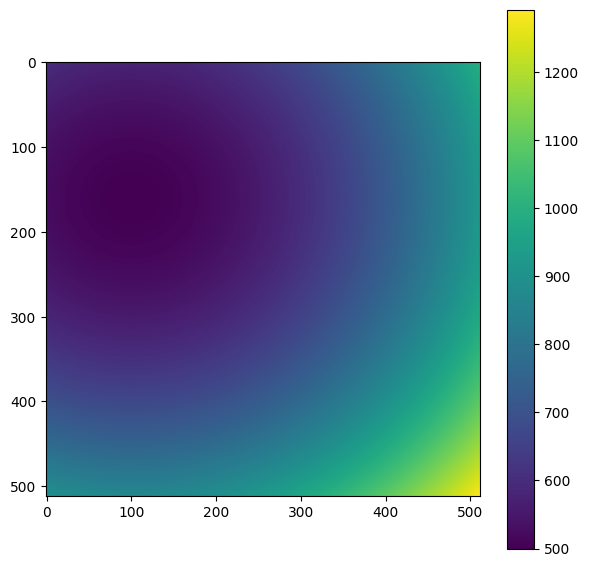

In [3]:
vel = np.fromfile(f_vel, dtype=np.float32).reshape((n1))
image(vel.reshape((nx, nz)))

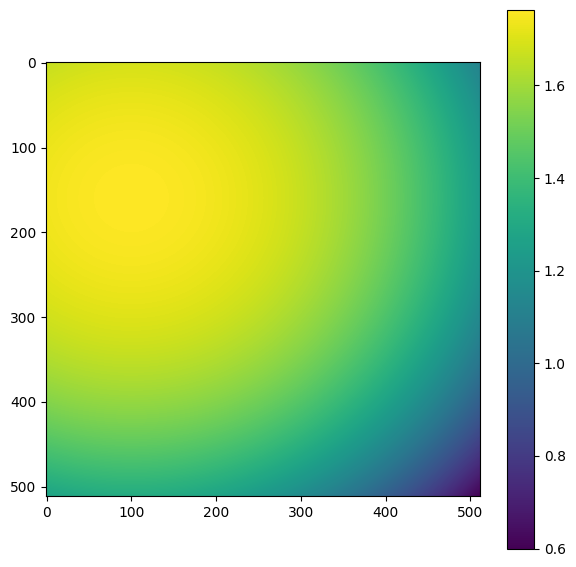

In [4]:
coeff = np.fromfile(f_coe, dtype=np.float32).reshape((13, n1))
image(coeff[0].reshape((nx, nz)))

### 1. 通过二阶多项式进行结果拟合

In [5]:
sorted_indices = np.argsort(vel)
sorted_vel = vel[sorted_indices]
sorted_coeff = coeff[0][sorted_indices]

In [6]:
x = sorted_vel
y = sorted_coeff
poly = np.poly1d(np.polyfit(x, y, 2))
y_new = poly(x)

C:\Users\sianh\AppData\Local\Temp\ipykernel_20608\371627066.py:3: RankWarning: Polyfit may be poorly conditioned
  poly = np.poly1d(np.polyfit(x, y, 2))


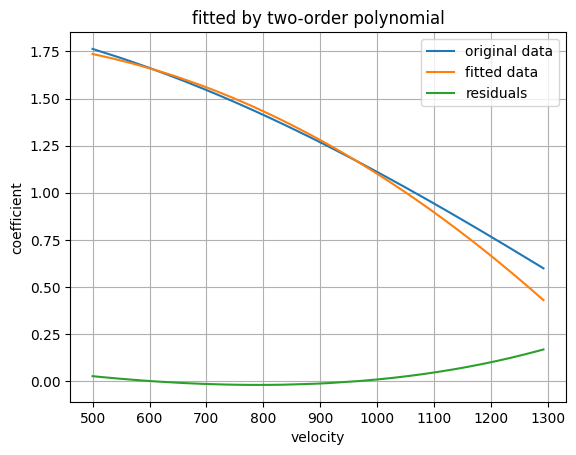

In [7]:
plt.plot(x, y, '-', label='original data')
plt.plot(x, y_new, '-', label='fitted data')
plt.plot(x, y - y_new, '-', label='residuals')
plt.legend()
plt.xlabel('velocity')
plt.ylabel('coefficient')
plt.title('fitted by two-order polynomial')
plt.grid(True)
plt.show()

### 2. 使用样条函数对系数进行插值

In [8]:
unique_vel, unique_indices = np.unique(sorted_vel, return_index=True)
unique_coeff = sorted_coeff[unique_indices]
cs = CubicSpline(unique_vel, unique_coeff, bc_type="natural")

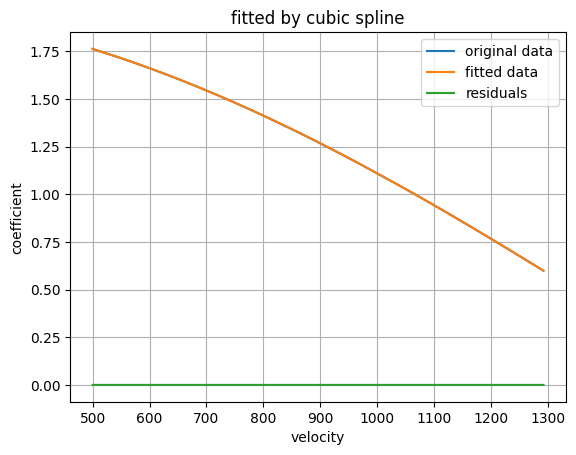

In [9]:
x = unique_vel
y = unique_coeff
y_new = cs(x)

plt.plot(x, y, '-', label='original data')
plt.plot(x, y_new, '-', label='fitted data')
plt.plot(x, y - y_new, '-', label='residuals')
plt.legend()
plt.xlabel('velocity')
plt.ylabel('coefficient')
plt.title('fitted by cubic spline')
plt.grid(True)
plt.show()

In [10]:
def createdata(x, y, ext=10, num=100000):
    # 跟据x进行排序
    sorted_indices = np.argsort(x)
    sorted_x = x[sorted_indices]
    sorted_y = y[sorted_indices]

    # 唯一化处理
    unique_x, unique_indices = np.unique(sorted_x, return_index=True)
    unique_y = sorted_y[unique_indices]

    # 构建插值函数
    cs = CubicSpline(unique_x, unique_y, bc_type="natural")

    # 构建阔边
    x_max, x_min = np.max(sorted_x) + ext, np.min(sorted_x) - ext
    x_new = np.linspace(x_min, x_max, num)
    y_new = cs(x_new)

    # 返回结果
    return unique_x, unique_y, x_new, y_new

In [11]:
y_new_list = []
x_new = any
for i in range(len(coeff)):
    unique_x, unique_y, x_new, y_new = createdata(vel, coeff[i], ext=0, num=100000)
    y_new_list.append(y_new)

y_new = np.array(y_new_list)

In [12]:
def plot(index=0):
    sorted_indices = np.argsort(vel)
    sorted_vel = vel[sorted_indices]
    sorted_coeff = coeff[index][sorted_indices]

    plt.plot(sorted_vel, sorted_coeff, '-', label='original data')
    plt.plot(x_new, y_new[index], '-', label='fitted data')
    plt.xlabel('velocity')
    plt.ylabel('coefficient')
    plt.title(f'fitted by cubic spline-{index}')
    plt.grid(True)
    plt.show()

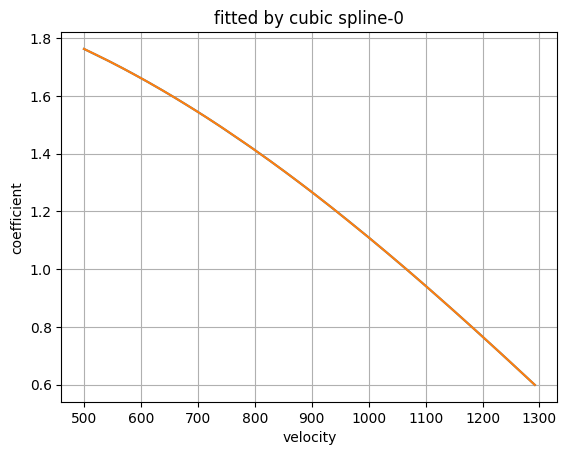

In [13]:
plot(0)

In [14]:
import torch
from torch import nn
import torch.optim as optim

In [74]:
class Swish(nn.Module):
    def __init__(self):
        super(Swish, self).__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.bn1 = nn.LayerNorm(64)
        self.fc2 = nn.Linear(64, 128)
        self.bn2 = nn.LayerNorm(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.LayerNorm(64)
        self.fc4 = nn.Linear(64, 13)
        self.activation = Swish()  # 也可以换成 nn.Swish()

    def forward(self, x):
        x = self.activation(self.bn1(self.fc1(x)))
        x = self.activation(self.bn2(self.fc2(x)))
        x = self.activation(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        # 输出层不用激活
        return x


model = Net().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [75]:
x_tensor = torch.from_numpy(x_new).unsqueeze(0).float().transpose(0, 1).cuda()
y_tensor = torch.from_numpy(y_new).float().transpose(0, 1).cuda()
print(x_tensor.shape)
print(y_tensor.shape)

print(f"vel = {x_tensor[0]}")
print(f"coeff = {y_tensor[0]}")

torch.Size([100000, 1])
torch.Size([100000, 13])
vel = tensor([500.], device='cuda:0')
coeff = tensor([ 1.7630e+00,  1.3600e-01, -2.2128e-02,  4.7397e-03, -8.5095e-04,
         8.8443e-05,  1.3600e-01, -2.2128e-02,  4.7397e-03, -8.5095e-04,
         8.8443e-05,  6.5937e-04,  6.5937e-04], device='cuda:0')


In [76]:
# 归一化处理
x_max, x_min = x_new.max(), x_new.min()
y_max, y_min = y_new.max(-1), y_new.min(-1)

print(f"x_max = {x_max}, x_min = {x_min}")
print(f"y_max = {y_max}, y_min = {y_min}")

y_max_tensor = torch.from_numpy(y_max).unsqueeze(0).float().cuda()
y_min_tensor = torch.from_numpy(y_min).unsqueeze(0).float().cuda()

y_tensor = (y_tensor - y_min_tensor) / (y_max_tensor - y_min_tensor)

print(f"y_max_tensor = {y_max_tensor.shape}")
print(f"y_min_tensor = {y_min_tensor.shape}")

x_max = 1291.905517578125, x_min = 500.0
y_max = [ 1.76297998e+00  7.61929572e-01 -2.21283734e-02  2.35401355e-02
 -8.50946817e-04  4.46128164e-04  7.61929572e-01 -2.21283734e-02
  2.35401355e-02 -8.50946817e-04  4.46128164e-04  2.82781925e-02
  2.82781925e-02], y_min = [ 5.99098861e-01  1.36001855e-01 -1.09484792e-01  4.73968033e-03
 -4.25873557e-03  8.84427718e-05  1.36001855e-01 -1.09484792e-01
  4.73968033e-03 -4.25873557e-03  8.84427718e-05  6.59366953e-04
  6.59366953e-04]
y_max_tensor = torch.Size([1, 13])
y_min_tensor = torch.Size([1, 13])


In [77]:
epochs = 2000
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x_tensor)

    loss = criterion(y_pred, y_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"pred coeff = {y_pred[0]}")
        print(f"Epoch {epoch}, Loss: {loss.item():.10f}")

pred coeff = tensor([ 0.2829,  0.0041,  0.3204, -0.5391,  0.5492, -0.4522, -0.3857,  0.0854,
        -0.2574, -0.5254,  0.2993,  0.0170,  0.0613], device='cuda:0',
       grad_fn=<SelectBackward0>)
Epoch 0, Loss: 0.4669204056
pred coeff = tensor([0.5537, 0.4568, 0.5153, 0.4828, 0.5180, 0.4793, 0.4575, 0.5156, 0.4829,
        0.5203, 0.4793, 0.3107, 0.3098], device='cuda:0',
       grad_fn=<SelectBackward0>)
Epoch 100, Loss: 0.0867570117
pred coeff = tensor([0.5528, 0.4575, 0.5155, 0.4830, 0.5190, 0.4791, 0.4575, 0.5155, 0.4830,
        0.5190, 0.4791, 0.3102, 0.3102], device='cuda:0',
       grad_fn=<SelectBackward0>)
Epoch 200, Loss: 0.0867561772
pred coeff = tensor([0.5528, 0.4575, 0.5155, 0.4830, 0.5190, 0.4791, 0.4575, 0.5155, 0.4830,
        0.5190, 0.4791, 0.3102, 0.3102], device='cuda:0',
       grad_fn=<SelectBackward0>)
Epoch 300, Loss: 0.0867554918
pred coeff = tensor([0.5528, 0.4575, 0.5155, 0.4830, 0.5190, 0.4791, 0.4575, 0.5155, 0.4830,
        0.5190, 0.4791, 0.3102, 0.31

In [78]:
x_test = torch.linspace(x.min(), x.max(), 1000).view(-1, 1).cuda()  # 归一化范围
y_pred = model(x_tensor)

y_pred = y_pred * (y_max_tensor - y_min_tensor) + y_min_tensor

In [79]:
y_int = y_pred.cpu().transpose(0, 1).detach().numpy()

In [80]:
def plotint(index=0):
    sorted_indices = np.argsort(vel)
    sorted_vel = vel[sorted_indices]
    sorted_coeff = coeff[index][sorted_indices]

    plt.plot(sorted_vel, sorted_coeff, '-', label='original data')
    plt.plot(x_new, y_int[index], '-', label='fitted data')
    plt.xlabel('velocity')
    plt.ylabel('coefficient')
    plt.title(f'fitted by cubic spline-{index}')
    plt.grid(True)
    plt.show()

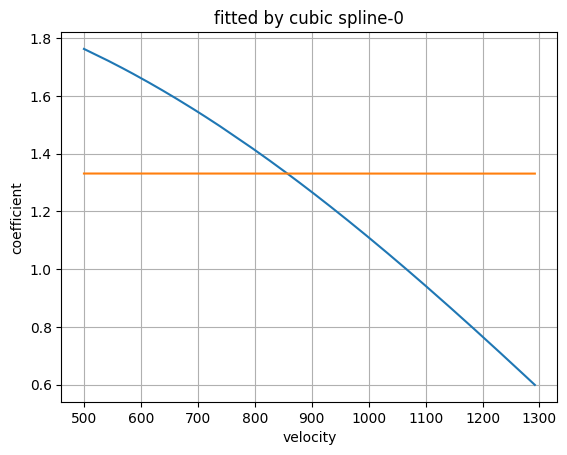

In [81]:
plotint(0)

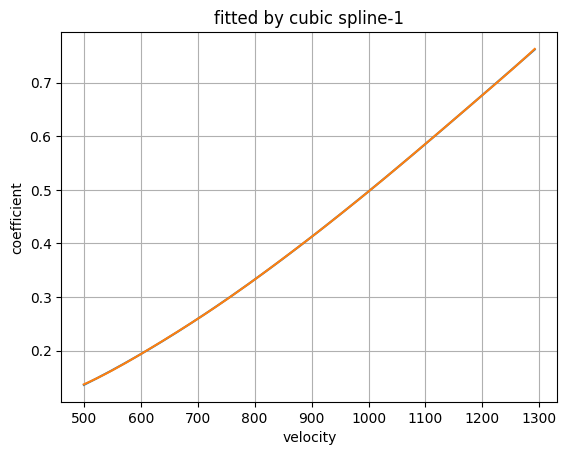

In [60]:
plotint(1)

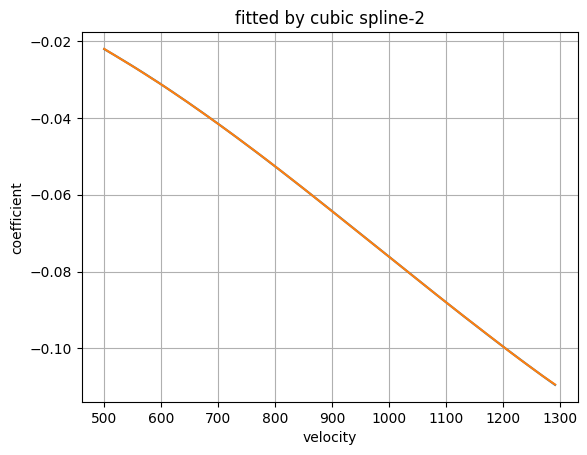

In [61]:
plotint(2)

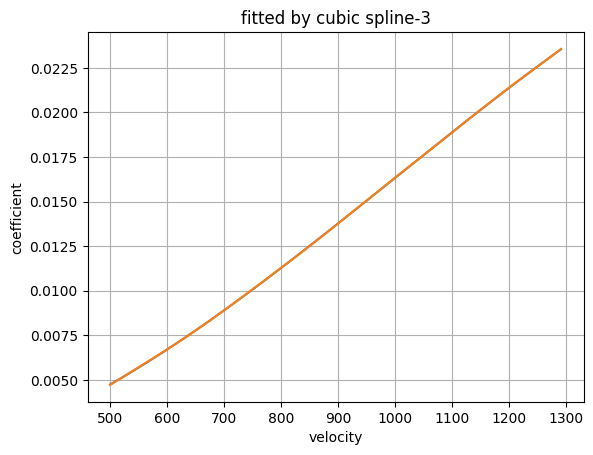

In [62]:
plotint(3)

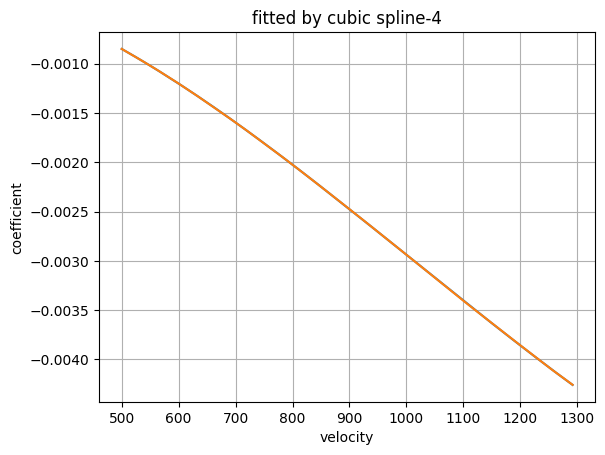

In [63]:
plotint(4)

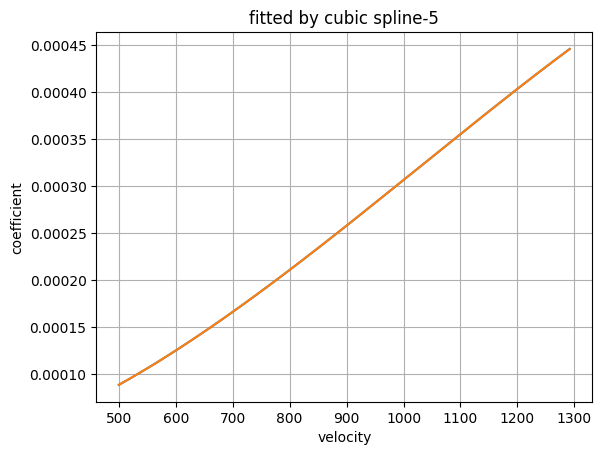

In [64]:
plotint(5)

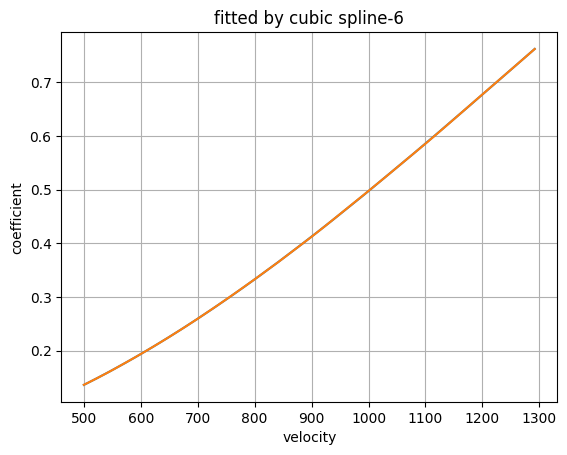

In [65]:
plotint(6)

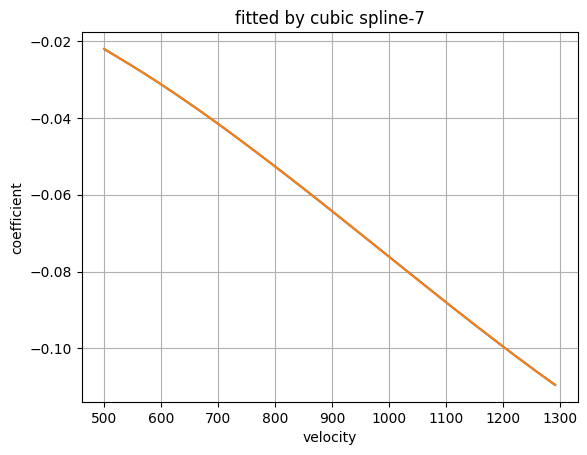

In [66]:
plotint(7)

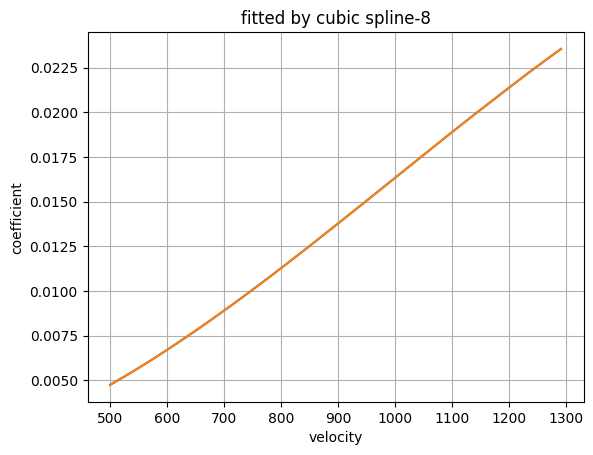

In [67]:
plotint(8)

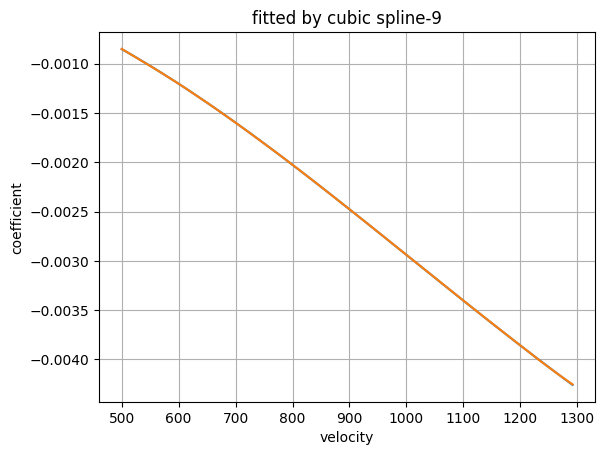

In [68]:
plotint(9)

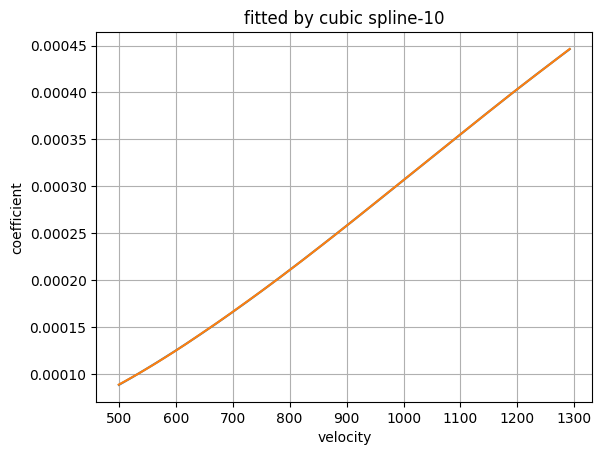

In [69]:
plotint(10)

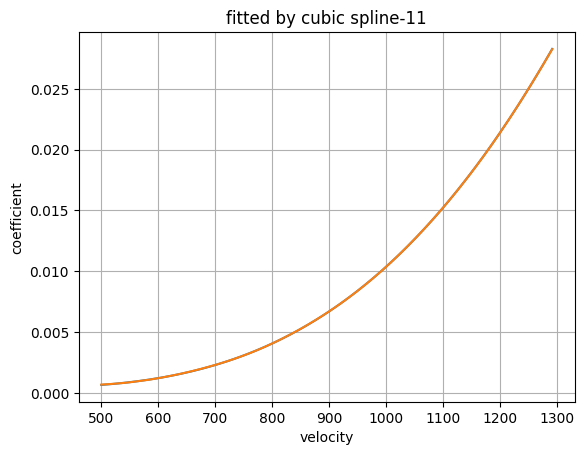

In [70]:
plotint(11)

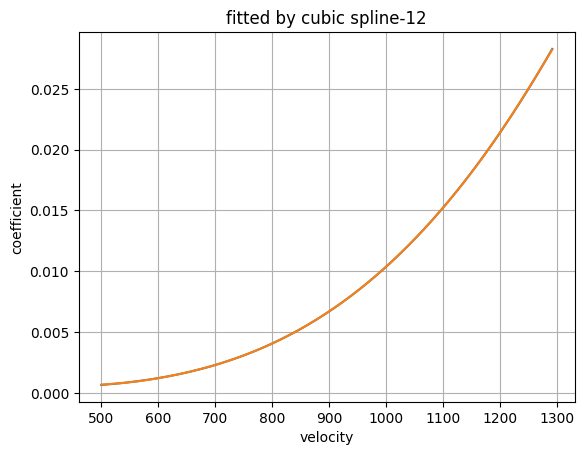

In [71]:
plotint(12)

In [72]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 18061


In [73]:
# vel_tensor = torch.from_numpy(vel).float().unsqueeze(1).cuda()

vel_tensor = torch.ones((1, 1)).cuda()
vel_tensor[0] = 500
print(f"vel_tensor = {vel_tensor}")
print(f"vel_tensor = {vel_tensor.shape}")
coeff_pred = model(vel_tensor)
coeff_pred = coeff_pred * (y_max_tensor - y_min_tensor) + y_min_tensor

coeff_int = coeff_pred.cpu().transpose(0, 1).detach().numpy()

vel_tensor = tensor([[500.]], device='cuda:0')
vel_tensor = torch.Size([1, 1])


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 64])

In [ ]:
image(coeff_int[0].reshape((nx, nz)))

In [ ]:
sorted_coeff_int = coeff_int[0][sorted_indices]

In [ ]:
plt.plot(sorted_vel, sorted_coeff, '-', label='original data')
plt.plot(x_new, coeff_int[0], '-', label='fitted data')
plt.legend()
plt.xlabel('velocity')
plt.ylabel('coefficient')
plt.title('fitted by two-order polynomial')
plt.grid(True)
plt.show()